## Imports

In [1]:
import numpy as np
import emcee
from tqdm import tqdm
import corner

In [2]:
import starry
print("Using `starry` version %s." % starry.__version__)

Using `starry` version 0.2.2.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
matplotlib.rcParams['axes.formatter.useoffset'] = False

## Define our velocity model

In [4]:
def get_ylm_coeffs(inc=90, obl=0, alpha=0):
    """
    Return the spherical harmonic coefficients for the RV profile of a star.
    
    The star has inclination `inc`, obliquity `obl`, and differential
    rotation shear `alpha`. See `DifferentialRotationWithSphericalHarmonics.ipynb`
    for details on how this was derived.
    """
    cosi = np.cos(inc * np.pi / 180)
    sini = np.sin(inc * np.pi / 180)
    cosl = np.cos(obl * np.pi / 180)
    sinl = np.sin(obl * np.pi / 180)
    A = sini * cosl
    B = sini * sinl
    C = cosi
    return np.array([0,
                     np.sqrt(3)*np.pi*B*(-A**2*alpha - B**2*alpha - C**2*alpha + 5)/15,
                     0,
                     np.sqrt(3)*np.pi*A*(-A**2*alpha - B**2*alpha - C**2*alpha + 5)/15,
                     0,
                     0,
                     0,
                     0,
                     0,
                     np.sqrt(70)*np.pi*B*alpha*(3*A**2 - B**2)/70,
                     2*np.sqrt(105)*np.pi*C*alpha*(-A**2 + B**2)/105,
                     np.sqrt(42)*np.pi*B*alpha*(A**2 + B**2 - 4*C**2)/210,
                     0,
                     np.sqrt(42)*np.pi*A*alpha*(A**2 + B**2 - 4*C**2)/210,
                     4*np.sqrt(105)*np.pi*A*B*C*alpha/105,
                     np.sqrt(70)*np.pi*A*alpha*(A**2 - 3*B**2)/70])

## Import the RV dataset generated by `wobble`

In [ ]:
time, rv, err = np.loadtxt("HD189733_rvs.txt", unpack=True, skiprows=1, delimiter=',')
idx = np.argsort(time)
time = time[idx]
rv = rv[idx]
err = err[idx]
tref = 2454279.0

## Define our priors

In [ ]:
class Normal(object):
    """A normal distribution."""
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    def sample(self):
        return self.mean + self.sigma * np.random.randn()
    def evaluate(self, x):
        return -0.5 * (x - self.mean) ** 2 / self.sigma ** 2

class Uniform(object):
    """A uniform distribution."""
    def __init__(self, low, high):
        self.low = low
        self.high = high
    def sample(self):
        return np.random.uniform(self.low, self.high)
    def evaluate(self, x):
        if (x < self.low) or (x > self.high):
            return -np.inf
        else:
            return 0

class Sine(object):
    """
    A sine distribution.
    
    This is an uninformative distribution for the 
    inclination of the stellar rotation axis.
    """
    def __init__(self):
        pass
    def sample(self):
        x = np.random.random()
        y = np.arccos(1 - x) * 180 / np.pi
        z = np.random.random()
        if z < 0.5:
            return 180 - y
        else:
            return y
    def evaluate(self, x):
        if x < 0 or x > 180:
            return -np.inf
        else:
            return np.log10(np.sin(x * np.pi / 180))

In [ ]:
class Prior:
    """A class containing all the information on our priors."""
    
    def __init__(self):
        self.params = ['veq', 'obl', 'inc', 'alpha', 'q1', 'q2', 
                       'baseline', 'K', 'b_t0', 'b_per', 
                       'b_inc', 'b_r', 'b_a', 'ln_err']
        
        self.names = [r'$v_\mathrm{eq}$',
                      r'$\lambda$',
                      r'$i$',
                      r'$\alpha$',
                      r'$q_1$',
                      r'$q_2$',
                      r'$v_\mathrm{0}$',
                      r'$K$',
                      r'$t_\mathrm{0,p}$',
                      r'$P_\mathrm{p}$',
                      r'$i_\mathrm{p}$',
                      r'$r_\mathrm{p}$',
                      r'$a$',
                      r'$\ln\sigma$']
        
        # The actual priors we use.
        # Some of these taken from Table 1 in Cegla et al. (2016)
        # Others are uniform / uninformative priors
        self.veq = Uniform(0, 1e4)
        self.obl = Uniform(-90, 90)
        self.inc = Sine()
        self.alpha = Uniform(-1, 1)
        self.q1 = Uniform(0, 1)
        self.q2 = Uniform(0, 1)
        self.baseline = Uniform(-10000, -9900)
        self.K = Uniform(180, 220)
        self.b_t0 = Normal(2454279.436714, 0.000015)
        self.b_per = Normal(2.21857567, 0.00000015)
        self.b_inc = Normal(85.710, 0.024)
        self.b_r = Normal(0.15667, 0.00012)
        self.b_a = Normal(8.863, 0.020)
        self.ln_err = Uniform(-3, 3)
        
        # Distributions for the initial MCMC step
        self.veq_guess = Normal(4500, 100)
        self.obl_guess = Normal(-0.4, 0.3)
        self.inc_guess = Normal(100, 2.0)
        self.alpha_guess = Uniform(-0.5, 0.5)
        self.q1_guess = Uniform(0, 1)
        self.q2_guess = Uniform(0, 1)
        self.baseline_guess = Normal(-9950.0, 3.0)
        self.K_guess = Normal(200.56, 0.88)
        self.b_t0_guess = Normal(2454279.436714, 0.000015)
        self.b_per_guess = Normal(2.21857567, 0.00000015)
        self.b_inc_guess = Normal(85.710, 0.024)
        self.b_r_guess = Normal(0.15667, 0.00012)
        self.b_a_guess = Normal(8.863, 0.020)
        self.ln_err_guess = Normal(0, 0.1)
        
    def evaluate(self, x):
        """Evaluate the log prior."""
        return np.sum([getattr(self, p).evaluate(x[i]) for i, p in enumerate(self.params)])

    def sample(self):
        """Sample from the prior distribution."""
        return [getattr(self, p).sample() for i, p in enumerate(self.params)]
    
    def guess(self):
        """Sample from the `guess' distribution."""
        return [getattr(self, p + "_guess").sample() for i, p in enumerate(self.params)]

In [ ]:
# Instantiate the prior
prior = Prior()

## Define our model and likelihood

In [ ]:
# Instantiate our `starry` system
star = starry.kepler.Primary(5)
planet = starry.kepler.Secondary(0)
system = starry.kepler.System(star, planet)
map_unif = starry.Map(1)

In [ ]:
def compute(x):
    """Compute the RV model given a parameter vector `x`."""
    # Get our params
    veq, obl, inc, alpha, q1, q2, baseline, K, b_t0, b_per, b_inc, b_r, b_a, ln_err = x
    
    # Planet params
    planet.tref = b_t0
    planet.porb = b_per
    planet.inc = b_inc
    planet.r = b_r
    planet.a = b_a
    
    # Stellar velocity profile and limb darkening
    star.reset()
    star[:3, :] += veq * get_ylm_coeffs(inc=inc, obl=obl, alpha=np.abs(alpha))
    sqrtq1 = np.sqrt(q1)
    star[1] = 2 * sqrtq1 * q2
    star[2] = sqrtq1 * (1 - 2 * q2)
    
    # Compute the light curve
    system.compute(time)

    # HACK: STARRY v0.2.2 requires the Y_{0,0} coefficient for the star to be
    # unity. But if we're using it to model velocity, we want the net velocity of
    # the star to be *zero* (after subtracting the orbital slope). We can hack this
    # by subtracting the model for a transit across a uniform star, like this:
    f_unif = map_unif.flux(xo=planet.X, yo=planet.Y, ro=planet.r)
    model = star.lightcurve / np.pi - f_unif
    
    # Add a baseline
    model += baseline - K * np.sin(2 * np.pi / b_per * (time - b_t0))
    
    return model

In [ ]:
def lnlike(x):
    """Return the prior times the log-likelihood for a parameter vector `x`."""
    # Evaluate the prior
    lp = prior.evaluate(x)
    if np.isinf(lp):
        return lp
    
    # Compute the model
    model = compute(x)
    
    # Compute the likelihood from chi-squared
    ln_err = x[-1]
    N = len(time)
    return lp - 0.5 * np.sum(((model - rv) / np.exp(ln_err)) ** 2) - N * ln_err

## Sample from the initial conditions a few times
... to verify we're off to a good start

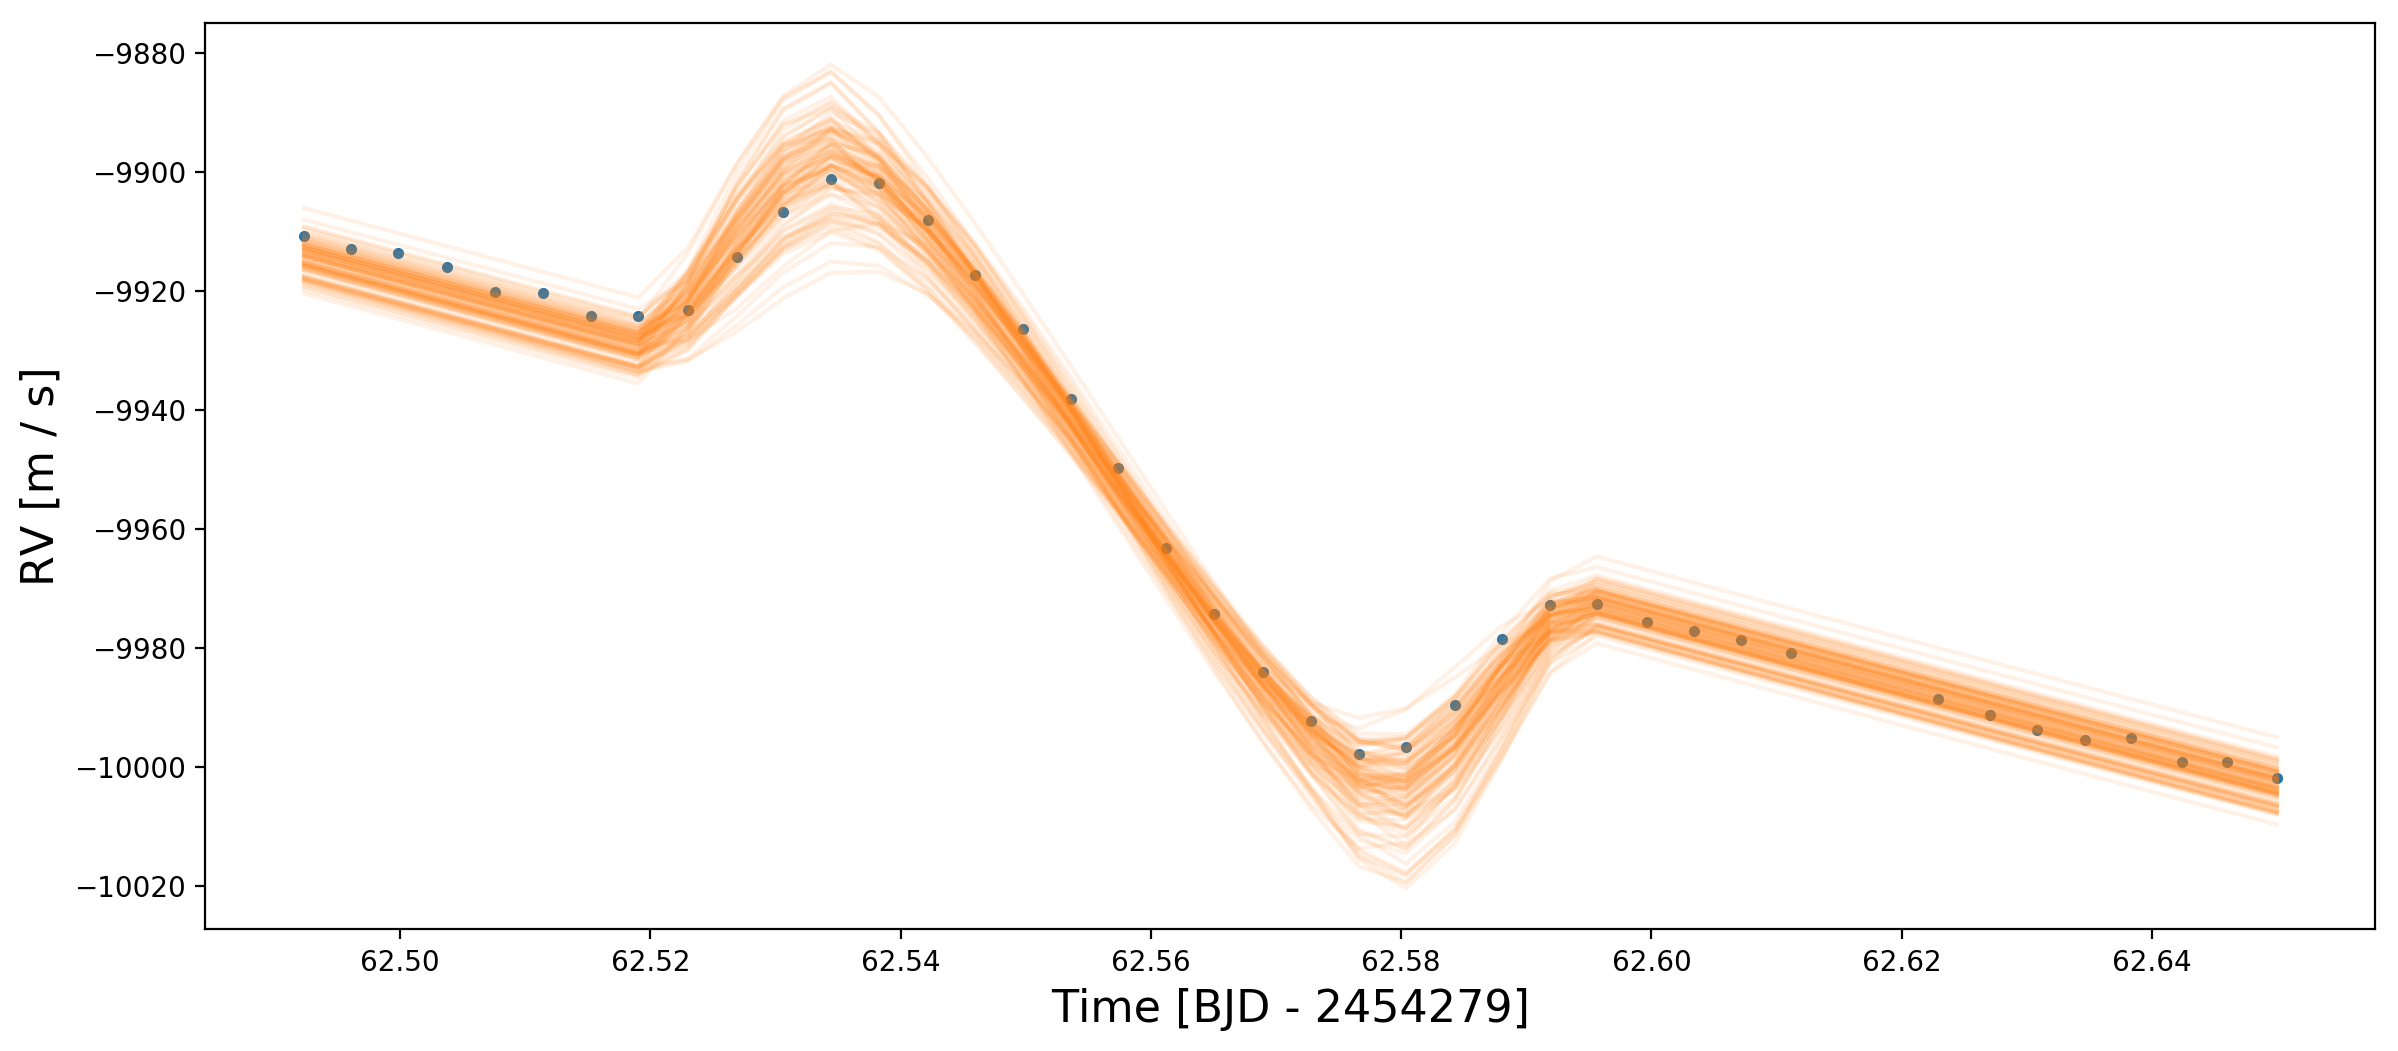

In [ ]:
fig = plt.figure(figsize=(14, 6))
plt.plot(time - tref, rv, '.')
plt.xlabel("Time [BJD - %d]" % tref, fontsize=16)
plt.ylabel("RV [m / s]", fontsize=16);

for i in range(100):
    model = compute(prior.guess())
    plt.plot(time - tref, model, 'C1', alpha=0.1)

## Let's do MCMC

In [ ]:
# Chain params
nsteps = 200000
nwalk = 100
ndim = 14
thin = 10
nburn = int(nsteps / 5)

# Run the chain, or load from disk?
RUN_CHAIN = True

In [ ]:
# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike, threads=8)

if RUN_CHAIN:
    # Initial guesses
    p0 = [prior.guess() for k in range(nwalk)]
    # Run our MCMC chain
    for i in tqdm(sampler.sample(p0, iterations=nsteps * thin, thin=thin), total=nsteps * thin):
        pass
    np.savez("bedell_quadld.npz", chain=sampler.chain, 
             lnprobability=sampler.lnprobability, iterations=sampler.iterations,
             naccepted=sampler.naccepted)
else:
    # Load the data
    data = np.load("bedell_quadld.npz")
    sampler._chain = data['chain']
    sampler._lnprob = data['lnprobability']
    sampler.iterations = int(data['iterations'])
    sampler.naccepted = data['naccepted']

  1%|          | 12532/2000000 [01:53<5:46:21, 95.64it/s] 

In [ ]:
# Transform some of the params
ndim = sampler.dim
labels = list(prior.names)
chain = np.array(sampler.chain)
lnprobability = np.array(sampler.lnprobability)

# Take the absolute value of alpha
chain[:, :, 3] = np.abs(chain[:, :, 3])

# Subtract the reference time from t0
chain[:, :, 8] -= tref
prior.b_t0.mean -= tref

# Compute the total 3D obliquity as in Cegla et al.
inc = chain[:, :, 2]
obl = chain[:, :, 1]
b_inc = chain[:, :, 10]
obl3d = np.arccos(np.sin(inc * np.pi / 180) * 
                  np.cos(obl * np.pi / 180) * 
                  np.sin(b_inc * np.pi / 180) + 
                  np.cos(inc * np.pi / 180) * 
                  np.cos(b_inc * np.pi / 180)).reshape(nwalk, nsteps, 1)
obl3d *= 180 / np.pi

# Compute u1 and u2
q1 = chain[:, :, 4]
q2 = chain[:, :, 5]
sqrtq1 = np.sqrt(q1)
u1 = (2 * sqrtq1 * q2).reshape(nwalk, nsteps, 1)
u2 = (sqrtq1 * (1 - 2 * q2)).reshape(nwalk, nsteps, 1)
chain = np.concatenate((chain, obl3d, u1, u2), axis=-1)
ndim += 3
labels += [r"$\psi$", r"$u_1$", r"$u_2$"]

In [ ]:
# Plot the chains
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1)
axc =  [plt.subplot2grid((9, 23), (n, 0), colspan=8, rowspan=1) for n in range(9)]
axc += [plt.subplot2grid((9, 23), (n, 13), colspan=8, rowspan=1) for n in range(9)]
axh =  [plt.subplot2grid((9, 23), (n, 8), colspan=2, rowspan=1, sharey=axc[n]) for n in range(9)]
axh += [plt.subplot2grid((9, 23), (n, 21), colspan=2, rowspan=1, sharey=axc[9 + n]) for n in range(9)]
alpha = 0.3

# Thin them a little
plot_thin = 100
burn_idx = np.arange(0, nburn, plot_thin)
prod_idx = np.arange(nburn, nsteps, plot_thin)

for i, label in enumerate(labels):
    # Plot the production part of the chains and fix the axis limits
    for k in range(nwalk):
        axc[i].plot(prod_idx, chain[k, nburn:, i][::plot_thin], alpha=alpha, lw=1)
        axc[i].set_ylabel(label, fontsize=18)
    axc[i].set_ylim(*axc[i].get_ylim())
    axc[i].set_xticklabels([])
    # Go back and plot the burn-in part
    axc[i].set_prop_cycle(None)
    for k in range(nwalk):
        axc[i].plot(burn_idx, chain[k, :nburn, i][::plot_thin], alpha=alpha, lw=1)
    axc[i].margins(0, None)
    axc[i].axvline(nburn, color="r", lw=1)
    # Plot the histogram for the production part
    axh[i].hist(chain[:, nburn:, i].flatten(), bins=30,
                orientation="horizontal", histtype='step',
                fill=False, color='k', lw=1)
    plt.setp(axh[i].get_yticklabels(), visible=False)
    plt.setp(axh[i].get_xticklabels(), visible=False)
    
# Plot the likelihood
for k in range(nwalk):
    axc[-1].plot(prod_idx, lnprobability[k, nburn:][::plot_thin], alpha=alpha, lw=1)
    axc[-1].set_ylabel(r"$\ln P$", fontsize=18)
axc[-1].set_ylim(*axc[-1].get_ylim())
axc[-1].set_prop_cycle(None)
for k in range(nwalk):
    axc[-1].plot(burn_idx, lnprobability[k, :nburn][::plot_thin], alpha=alpha, lw=1)
axc[-1].margins(0, None)
axc[-1].axvline(nburn, color="r", lw=1)
axc[-1].set_xticklabels([])
axh[-1].axis('off')
plt.setp(axh[-1].get_yticklabels(), visible=False)
plt.setp(axh[-1].get_xticklabels(), visible=False);

for ax in axc:
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(6) 
fig.align_ylabels(axc[:9]);
fig.align_ylabels(axc[9:]);

# Save!
fig.savefig("hd189_chains.pdf", bbox_inches="tight")

In [ ]:
# Plot the data + model
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(time - tref, rv, '.', label="Data")
ax[0].set_ylabel("RV [m / s]", fontsize=14);

# Plot 500 random samples
for i in range(500):
    idx = np.random.randint(0, nwalk * nsteps)
    model = compute(sampler.flatchain[idx])
    ax[0].plot(time - tref, model, color='C1', alpha=0.1, lw=1)

# Plot the max like model
idx = np.argmax(sampler.flatlnprobability)
model = compute(sampler.flatchain[idx])
ax[0].plot(time - tref, model, color='k', lw=1, label="MAP");

# Hack a legend
ax[0].set_xlim(*ax[0].get_xlim())
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].plot([0, 0], [0, 0], color='C1', alpha=1, lw=1, label="Random samples")
ax[0].legend()

# Plot the residuals
ax[1].plot(time - tref, rv - model, '.');
ax[1].plot(time - tref, rv - model, '-', color='C0', lw=1);
ax[1].errorbar(time - tref, rv - model, err, fmt='none', color='C0', alpha=0.5)
ax[1].axhline(0, color='k', ls='--', alpha=0.5);
ax[1].set_xlabel("Time [BJD - %d]" % tref, fontsize=14)
ax[1].set_ylabel("Residuals [m / s]", fontsize=14);
fig.align_ylabels();

# Save!
fig.savefig("hd189_samples.pdf", bbox_inches="tight")

In [ ]:
# Plot the corner plot for all params
samples = chain[:, nburn:, :].reshape(nwalk * (nsteps - nburn), ndim)

# Thin them a tiny bit
corner_thin = 10
samples = samples[::corner_thin]

# Plot
fig = corner.corner(samples, labels=labels, bins=50);

# Plot the priors
for ind in range(ndim):
    if ind < len(prior.params):
        x = np.array([getattr(prior, prior.params[ind]).sample() 
                      for i in range(len(samples))])
        ax = fig.axes[(ndim + 1) * ind]
        n, _, _ = ax.hist(x, bins=50, weights=None,
                          range=np.sort([x.min(), x.max()]),
                          histtype="step", color="C0")
            
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

# Save!
fig.savefig("hd189_corner.pdf", bbox_inches="tight")

In [ ]:
# Reproduce Figure 4 in Cegla et al.
inds = [3, 0, 2, 1, 14]
samples_cegla = np.array([samples[:, inds[0]],
                          samples[:, inds[1]],
                          samples[:, inds[2]],
                          samples[:, inds[3]],
                          samples[:, inds[4]]]).T
labels_cegla = [labels[i] for i in inds]

# Corner plot
fig = corner.corner(samples_cegla, labels=labels_cegla, bins=50);
    
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    
# Save!
fig.savefig("hd189_corner_cegla.pdf", bbox_inches="tight")

**Compare this to:**



![](cegla_fig4.png)